# Implementing Probablistic Matrix Factorization
In this notebook, we design a probablistic implementation of matrix factorization to address the problem of missing values. This is a common problem in recommender systems where the data is often in the form of a ratings matrix where the entry in the $i$th row and $j$th column represents user $i$'s rating for item $j$. Because most users do not rate all items and most items are not rated by all users, matrix factorization offers a means of imputing these missing values.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

# MovieLens Ratings Data
The MovieLens dataset is one of the most popular benchmark datasets for testing recommender systems. It consists of nothing more than three attributes:
- user: integers representing the indices of the users
- item: integers representing the indices of the films
- rating: real numbers representing the rating given. this attribute has already been mean-centered.

The training set consists of $95,000$ ratings comprising $1,676$ unique movies and $943$ unique users. The test set consists of $5,000$ ratings. 

In [7]:
# read text document of movie names. a movie's index corresponds to its
# row number
with open('data/movies/movies.txt', 'rt') as f:
    movies = f.readlines()

# remove newlines from each movie name
movies = [movie.strip('\n') for movie in movies]

# create two-way mappings from movie to index
movie2idx = dict(zip(movies, list(range(len(movies)))))
idx2movie = dict(zip(list(range(len(movies))), movies))
map = dict(movie2idx=movie2idx, idx2movie=idx2movie)

# import ratings data and rename columns
df_train = pd.read_csv('data/movies/ratings.csv', header=None)
df_test = pd.read_csv('data/movies/ratings_test.csv', header=None)

columns = ['user', 'item', 'rating']
df_train.columns = columns
df_test.columns = columns

# convert indices from 1-based index to 0-based index
df_train['item'] = df_train['item'].apply(lambda x: x-1)
df_test['item'] = df_test['item'].apply(lambda x: x-1)
df_train['user'] = df_train['user'].apply(lambda x: x-1)
df_test['user'] = df_test['user'].apply(lambda x: x-1)

print('{} unique movies in training set'.format(df_train['item'].nunique()))
print('{} unique users in training set'.format(df_train['user'].nunique()))

df_train.head()

1676 unique movies in training set
943 unique users in training set


,user,item,rating
0,195,241,-0.53039
1,185,301,-0.53039
2,243,50,-1.53040
3,165,345,-2.53040
4,297,473,0.46961


# Probabilistic Matrix Factorization 
Let $M \in \mathbb{R}^{m \times n}$ be a ratings matrix where row $i$ represents all the ratings user $i$ has made, and column $j$ represents all the ratings given to item $j$. PMF seeks to factorize $M$ into $U \in \mathbb{R}^{k \times m}$ and $V \in \mathbb{R}^{k \times m}$ such that $M \approx U^TV$. Column $i$ of $U$ is a $k$-dimensional latent representation of user $i$, while column $j$ of $V$ is a $k$-dimensional representation of item $j$ in the same latent space.  To perform **maximum a posteriori** estimation for the values of $U$ and $V$, a generative model is required that assumes: 
- latent user vectors are distribtued $u_i \sim \mathcal{N}(0, \lambda^{-1}I)$ 
- latent item vectors are distributed $v_j \sim \mathcal{N}(0, \lambda^{-1}I)$ 
- ratings are distributed $M_{ij} \sim \mathcal{N}(u_i^Tv_j, \sigma^2)$ where $\lambda$ is a regularization parameter and $\sigma^2$ indicates expected noise.

Let $\Omega = \{(i,j):M_{ij}$ contains a rating $\}$ (in other words, $(i, j) \in \Omega$ if user $i$ rated item $j$, $\Omega_{u_i}$ be the index set of items rated by user $i$, and $\Omega_{v_j}$ be the index set of users who rated item $j$. Given the above assumptions, the joint likelihood of $p(M_O, U, V)$ (where $M_O$ indicates observed values of $M$) can be factorized as follows:

$$p(M_O, U, V) = [\prod_{(i,j)\in\Omega} p(M_{ij}|u_i, v_j)] \times [\prod_{i=1}^{m}p(u_i)] \times [\prod_{j=1}^{n}p(v_j)]$$

The MAP solution for $U$ and $V$ is the maximum of the log joint likelihood:

$$U_{MAP}, V_{MAP} = \arg\max_{U,V} \sum_{(i,j)\in\Omega}\ln p(M_{ij}|u_i, v_j) + \sum_{i=1}^{m}\ln p(u_i) + \sum_{j=1}^{n}\ln p(v_j)$$
$$= -\sum_{(i,j)\in\Omega}\frac{1}{2\sigma^2}\left\|M_{ij}-u_i^Tv_j\right\|^2-\sum_{i=1}^{m}\frac{\lambda}{2}\left|u_i\right\|^2 - \sum_{j=1}^{n}\frac{\lambda}{2}\left\|v_j\right\|^2 + C$$
where $C$ is some constant.

To update each $u_i$ and $v_j$, we take set the derivative of the joint log likehood to $0$ and solve for $u_i$ and $v_j$, resulting in:

$$u_i = (\lambda\sigma^2I+\sum_{j\in\Omega_{u_i}}v_jv_j^T)^{-1}(\sum_{j\in\Omega_{u_i}}M_{ij}v_j)$$

$$v_j = (\lambda\sigma^2I+\sum_{j\in\Omega_{v_j}}u_iu_i^T)^{-1}(\sum_{j\in\Omega_{v_j}}M_{ij}u_i)$$

Since all $u_i$'s and $v_j$'s cannot be solved simultaneously, an iterative coordinate ascent algorithm is used whereby $V$ is fixed while $U$ is optimized and then $U$ is fixed while $V$ is optimized.

In [183]:
class MatrixFactorization():
    
    def __init__(self, noise=0.25, n_components=10, lambd=1, n_iter=100):
        self.noise = noise
        self.n_components = n_components
        self.lambd = lambd
        self.n_iter = n_iter
        
        # part of the log joint likelihood depends only on
        # hyperparameters
        M = np.log(1 / np.sqrt(noise * 2 * np.pi))
        U = np.log(1 / np.sqrt((2 * np.pi) ** n_components * \
                               np.linalg.det(1/lambd * np.eye(n_components))))
        V = U
        self.likelihood_constants = dict(M=M, U=U, V=V)
        
    def fit(self, X):
        self.n_users = X['user'].max() + 1
        self.n_items = X['item'].max() + 1
        
        # randomly initialize factor matrics U and V
        # each column of U and V is a latent representation
        # n_components x n_users
        self.U = np.random.multivariate_normal(np.zeros(self.n_components),
                                               np.eye(self.n_components),
                                               self.n_users).T
        
        # n_components x n_items
        self.V = np.random.multivariate_normal(np.zeros(self.n_components),
                                               np.eye(self.n_components),
                                               self.n_items).T
        
        self.likelihoods = list()
        for index in range(1, self.n_iter + 1):
            
            # calculate log joint likelihood
            likelihood = self.calculate_log_joint_likelihood(X)
            self.likelihoods.append(likelihood)
            print('iteration {}, likelihood = {}'.format(index, likelihood)) 
            
            for i in range(self.n_users):
                
                # get indices for all items and ratings by user i
                X_filtered = X.loc[X['user'] == i]
                user_items = X_filtered['item'].values
                user_ratings = X_filtered['rating'].values
                
                # get only columns of V corresponding to items user i has rated
                V_filtered = self.V[:, user_items]
                
                # calculate latent vector
                first = np.linalg.inv(\
                        self.lambd * self.noise * np.eye(self.n_components) + \
                        V_filtered.dot(V_filtered.T))
                second = V_filtered.dot(user_ratings)
                self.U[:,i] = first.dot(second)
            
            for j in range(self.n_items):
                # get indices for all users and ratings for item j
                X_filtered = X.loc[X['item'] == j]
                item_users = X_filtered['user'].values
                item_ratings = X_filtered['rating'].values
                
                # get only columns of U corresponding to users that
                # have rated item j
                U_filtered = self.U[:, item_users]
                
                # calculate latent vector
                first = np.linalg.inv(\
                        self.lambd * self.noise * np.eye(self.n_components) + \
                        U_filtered.dot(U_filtered.T))
                second = U_filtered.dot(item_ratings)
                self.V[:,j] = first.dot(second)
                
            clear_output()
            
        return self
        
    def predict(self, X):
        predictions = list()
        for index, row in X.iterrows():
            i = int(row['user'])
            j = int(row['item'])
            
            # calculate prediction as dot product between latent vectors
            predictions.append(self.U[:,i].dot(self.V[:,j]))
            
        return np.array(predictions)
    
    def calculate_log_joint_likelihood(self, X):
        
        # calculate sum of squared errors
        preds = self.predict(X)
        ratings = X['rating'].values
        error = np.sum((ratings - preds) ** 2)
        
        # calcualte sum of squared norms for each factor matrix
        U_penalty = np.sum(np.linalg.norm(self.U, axis=0) ** 2)
        V_penalty = np.sum(np.linalg.norm(self.V, axis=0) ** 2)
        
        # calculate log joint likelihood in two parts
        log_joint_likelihood = -(1/(2 * self.noise)) * error - \
                                (self.lambd / 2) * U_penalty - \
                                (self.lambd / 2) * V_penalty
        
        # the second part accounts for the constants in the likelihood equation
        log_joint_likelihood += len(X) * self.likelihood_constants['M'] + \
                                self.n_users * self.likelihood_constants['U'] + \
                                self.n_items * self.likelihood_constants['V']
                
        return log_joint_likelihood
    
    def get_similar_items(self, item, n=10):
        
        # select latent item vector and calculate Euclidean distances to all
        # other latent item vectors
        item_vector = self.V[:, item].reshape(-1, 1)
        distances = np.linalg.norm(self.V - item_vector, axis = 0)
        
        # the most similar item will be the item itself, so exclude it
        similar_items = np.argsort(distances)[1:n+1]
        similar_distances = distances[similar_items]
        
        # package most similar items with corresponding distances
        data = dict(item=similar_items, distance=similar_distances)
        return pd.DataFrame(data)[['item', 'distance']]

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

For the MovieLens data, we use the matrix factorization model's default settings of $\sigma^2 = 0.25$, $k = 10$, and $\lambda = 1$ and fit it on the training set for $100$ iterations. For each user-movie pair in the test set, we predict the rating using the dot product of the relevant latent vectors in $U$ and $V$.

In [185]:
models = [MatrixFactorization().fit(df_train) for i in range(10)]

The learning curves for iterations $2$ through $100$ of $10$ matrix factorization models are plotted below.

Text(0,0.5,'log joint likelihood')

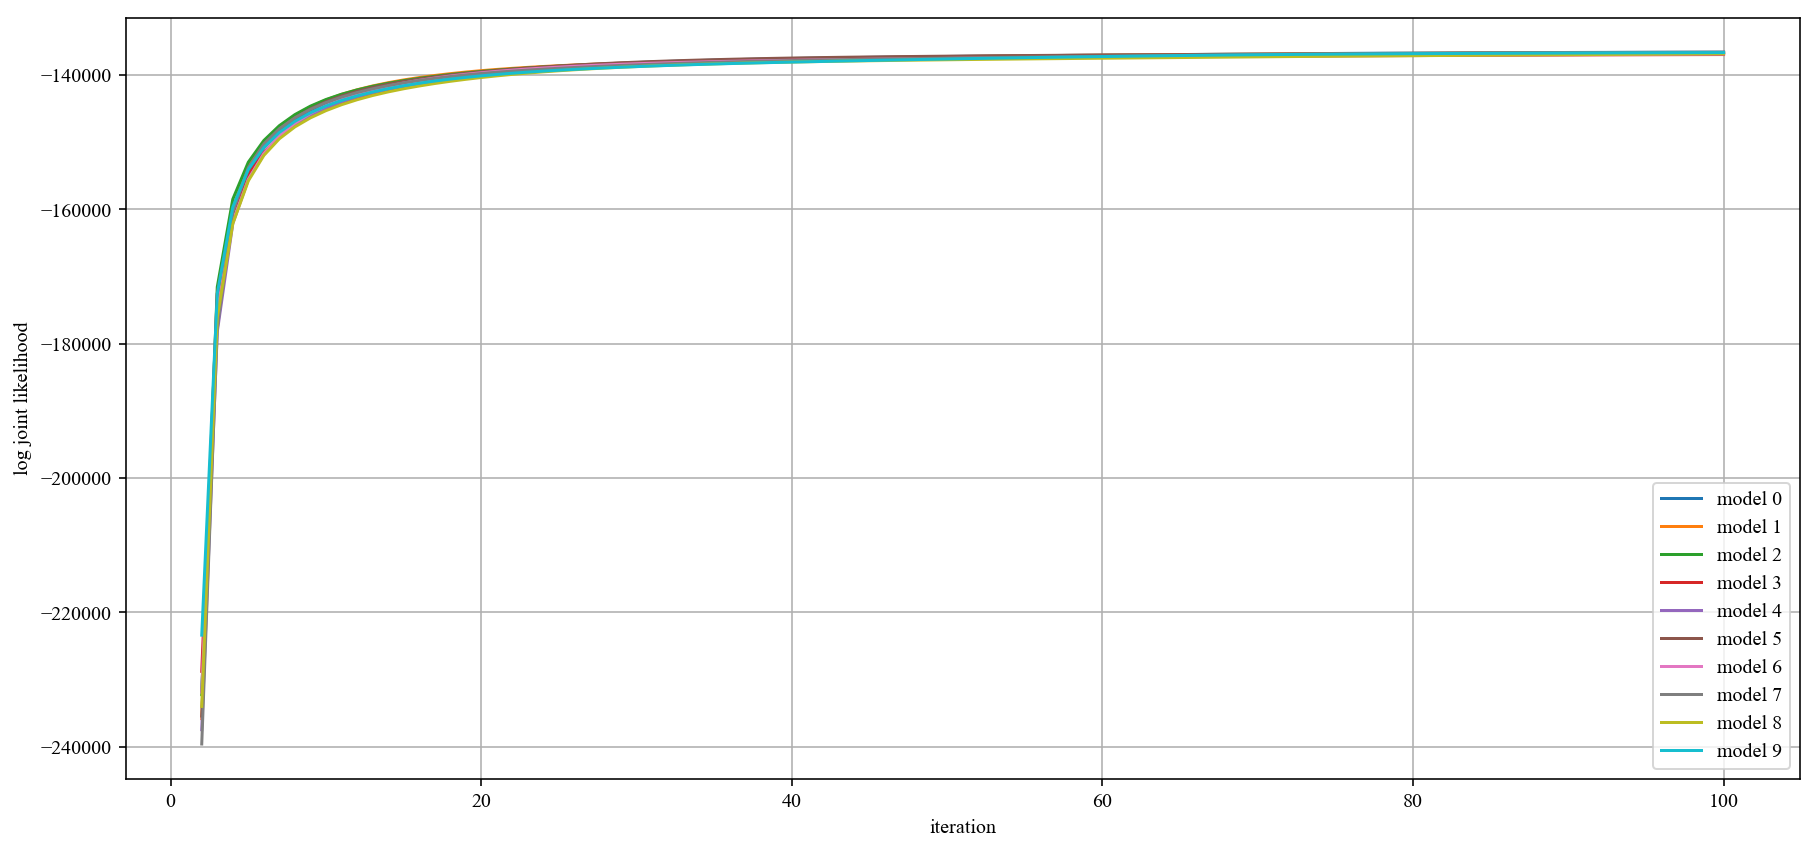

In [186]:
plt.figure(figsize = (15,7))
for i, model in enumerate(models):
    plt.plot(list(range(2, len(model.likelihoods)+1)), model.likelihoods[1:], label='model {}'.format(i))
    
plt.legend()
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('log joint likelihood')

For each model, we evaluate its performance on the test set using RMSE.

In [187]:
final_likelihoods = [model.likelihoods[-1] for model in models]
test_rmses = [rmse(df_test['rating'].values, model.predict(df_test)) for model in models]

data = dict(objective=final_likelihoods, rmse=test_rmses)
results_df = pd.DataFrame(data)
results_df = results_df.sort_values(by = 'objective', ascending=False)
best_model = models[int(results_df.head(1).index.values)]
results_df

,objective,rmse
7,-136591.986519,1.108886
0,-136592.909025,1.102305
1,-136652.005131,1.117883
9,-136658.650814,1.111010
5,-136693.414046,1.100956
4,-136723.469701,1.086885
2,-136750.638206,1.124118
8,-136838.399594,1.103811
6,-136872.128269,1.106308
3,-136946.702970,1.099346


Using the model with the best final objective value, we examine its learned latent vectors by finding the 10 most similar movies to "Star Wars", "My Fair Lady", and "Goodfellas". The results suggest the model has indeed learned a useful embedding of the films.

In [197]:
query_items = ['Star Wars (1977)', 'My Fair Lady (1964)', 'GoodFellas (1990)']

for query in query_items:
    query_index = map['movie2idx'][query]
    print(query.upper())
    print('=====================')
    df = best_model.get_similar_items(query_index)
    df['item'] = df['item'].apply(lambda x: map['idx2movie'][x])
    df.index = df.index + 1
    print(df)
    print('\n\n')

STAR WARS (1977)
                                                 item  distance
1                     Empire Strikes Back, The (1980)  0.315338
2                      Raiders of the Lost Ark (1981)  0.562862
3                           Return of the Jedi (1983)  0.610612
4                               Close Shave, A (1995)  0.840979
5           Indiana Jones and the Last Crusade (1989)  0.848903
6                               My Man Godfrey (1936)  0.997193
7                          Usual Suspects, The (1995)  1.026034
8                                   Sting, The (1973)  1.026902
9               Day the Earth Stood Still, The (1951)  1.039953
10  Wallace & Gromit: The Best of Aardman Animatio...  1.048119



MY FAIR LADY (1964)
                                      item  distance
1                      Mary Poppins (1964)  0.600331
2               Sound of Music, The (1965)  0.670181
3   Snow White and the Seven Dwarfs (1937)  0.701087
4                           Sabrina (1954)  